<a href="https://colab.research.google.com/github/mzuhh/ElectricityGermany/blob/main/ARIMA_hourly_v6_abgabe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Git Clone Pull

In [ ]:
#Install git
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [ ]:
#Clone Git Repo
#Insert Code from ReamMe here
#User Git Config
#Insert code from ReadMe here

In [ ]:
import os
if os.getcwd() != "/content/ElectricityGermany":
    %cd /content/ElectricityGermany
!git pull

/content/ElectricityGermany
Already up to date.


# PIP Install and PYTHON_ENV setup

In [ ]:
#Essential
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 25.5 MB/s eta 0:00:00


In [ ]:
#Optional
!pip install --upgrade --no-deps patsy
!pip install --upgrade matplotlib
!pip install --upgrade --no-deps statsmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


# ARIMA Model

## Imports

In [ ]:
import os
import uuid
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.stats import boxcox

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from pmdarima.arima import auto_arima

## Directories and file paths

In [ ]:
#Execution in Google Colab always evaluates 'else'
os.environ['PYTHON_ENV'] = 'colab'
#git trigger
# Define directory and file path: Yupiter Notebook ->
if os.getenv('PYTHON_ENV') == 'pycharm':
    data_dir = ''
else:
    data_dir = '/content/ElectricityGermany/data'

file_name = 'day_ahead_price_germany_J.csv'
file_path = os.path.join(data_dir, file_name)
df = pd.read_csv(file_path)

In [ ]:
# Maintenance and sessions organization variables
session_id_long = str(uuid.uuid4()) #Session ID
session_id = session_id_long.split('-')[0] #Session ID shortened
saved_file_counter = 0 #Counter for saved files

start_time = datetime.now().strftime("%Y_%m_%d_%H_%M_%S") #Start timestamp of a sesseion
end_time = datetime.now().strftime("%Y_%m_%d_%H_%M_%S") #End timestamp of a session

# Model local variables
date_column_name = 'date'
value_column_name = 'value'
#todelete#start_data_series = "2022-01-01T00:00"
start_data_series = datetime.strptime("2022-01-01T00:00", "%Y-%m-%dT%H:%M")

#start_date_training = datetime.strptime("2022-01-01T00:00", "%Y-%m-%dT%H:%M")
start_date_training = datetime.strptime("2022-01-01T00:00", "%Y-%m-%dT%H:%M")

end_date_training = datetime.strptime("2023-09-30T23:00", "%Y-%m-%dT%H:%M")
#end_date_training = datetime.strptime("2022-03-31T23:00", "%Y-%m-%dT%H:%M")

start_date_testing = datetime.strptime("2023-10-01T00:00", "%Y-%m-%dT%H:%M")
#start_date_testing = datetime.strptime("2022-03-31T23:00", "%Y-%m-%dT%H:%M")

#For day_ahead_price_germany_J.csv
end_date_testing = datetime.strptime("2024-01-02T23:00", "%Y-%m-%dT%H:%M")
#end_date_testing = datetime.strptime("2022-04-01T23:00", "%Y-%m-%dT%H:%M")

# Extract dates for plots
start_data_series_year_month = start_data_series.strftime("%Y-%m")
start_date_training_year_month = start_date_training.strftime("%Y-%m")
end_date_training_year_month = end_date_training.strftime("%Y-%m")
start_date_testing_year_month = start_date_testing.strftime("%Y-%m")
end_date_testing_year_month = end_date_testing.strftime("%Y-%m")

plot_main_title = "Day Ahead Auction Price (EUR/MWh)"
nsteps = 1
arima_model_order = (1,1,1)

print(arima_model_order)
print(start_date_training)
print(end_date_training)
print(start_date_testing)
print(session_id)
print(start_time)
print(end_time)
print(start_data_series_year_month)
print(start_date_training_year_month)
print(end_date_training_year_month)
print(start_date_testing_year_month)
print(end_date_testing_year_month)


(1, 1, 1)
2022-01-01 00:00:00
2022-03-31 23:00:00
2022-03-31 23:00:00
6c917617
2024_06_27_02_31_26
2024_06_27_02_31_26
2022-01
2022-01
2022-03
2022-03
2022-04


In [ ]:
#Creating a new directory for a session
directory = f"/content/ElectricityGermany/session_reports/arima_model_info_{start_time}_{session_id}"
if not os.path.exists(directory):
    os.makedirs(directory)
print(f"Directory '{directory}' created successfully")

Directory '/content/ElectricityGermany/session_reports/arima_model_info_2024_06_27_02_31_26_6c917617' created successfully


In [ ]:
#Remove time zone marker
def remove_tz(data_tz):
  return data_tz.split('+')[0]

#Remove T marker
def remove_T(data_T):
  return data_T.split('T')[0]

In [ ]:
#Cleaning df from time zone without shift
df[date_column_name] = df[date_column_name].apply(remove_tz)

In [ ]:
#Create additional df for more readable plots (removes hourly intervals)
df_plot = df
df_plot[date_column_name] = df_plot[date_column_name].apply(remove_T)
df_plot[date_column_name] = pd.to_datetime(df[date_column_name], format="%Y-%m-%d", errors="coerce")
df_plot = df_plot.set_index(date_column_name)[value_column_name]
df_plot

date
2022-01-01    50.05
2022-01-01    41.33
2022-01-01    43.22
2022-01-01    45.46
2022-01-01    37.67
              ...  
2024-01-02    63.18
2024-01-02    57.11
2024-01-02    46.89
2024-01-02    40.00
2024-01-02     7.43
Name: value, Length: 17568, dtype: float64

In [ ]:
#Date as index
df = df.set_index(date_column_name)
#Splitting df into training and testing sets
df_daily_training = df[start_date_training:end_date_training]
df_daily_test = df[start_date_testing:end_date_testing]

In [ ]:
#Initializing new df to be used only for plotting
df_plot_training = df_plot[start_date_training:end_date_training]
df_plot_test = df_plot[start_date_testing:end_date_testing]

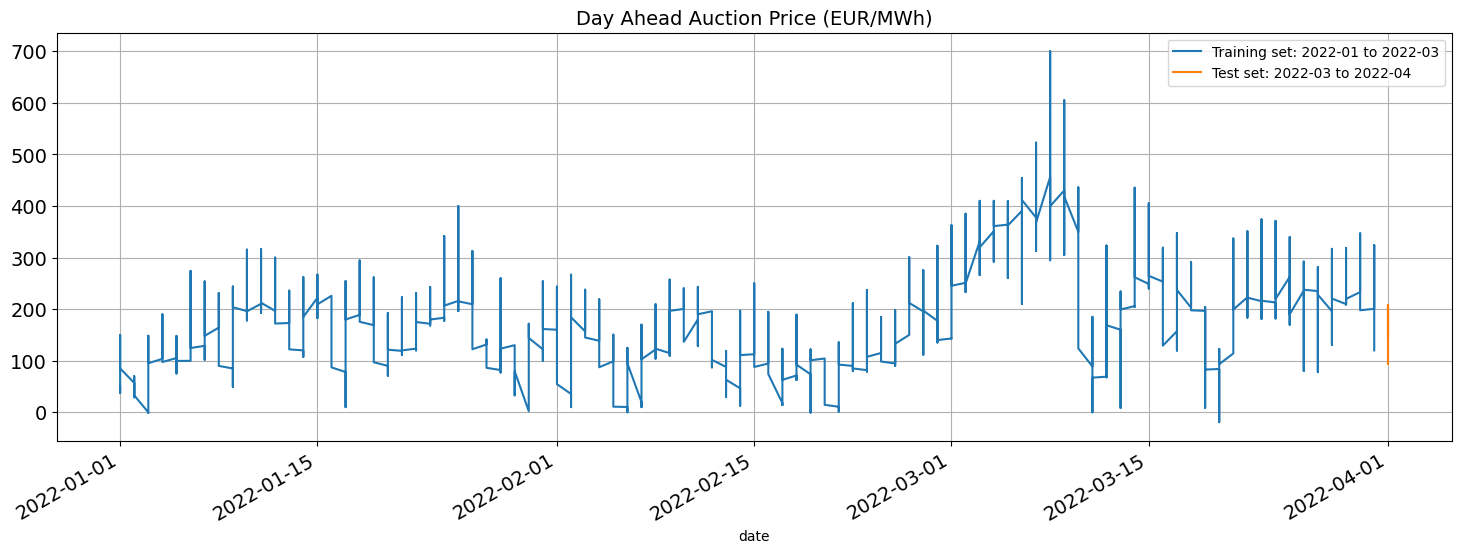

In [ ]:
#Day Ahead Auction Price (EUR/MWh)
plt.figure(figsize=(18, 6))
plt.title(plot_main_title, fontsize=14)


df_plot_training.plot(label=f"Training set: {start_date_training_year_month} to {end_date_training_year_month}", fontsize=14)
df_plot_test.plot(label=f"Test set: {start_date_testing_year_month} to {end_date_testing_year_month}", fontsize=14)

plt.grid(True)
plt.legend()


plt.gcf()
plot_main_title_save_file = plot_main_title.replace(' ', '_')
plot_main_title_save_file = plot_main_title_save_file.replace('/','')
saved_file_counter += 1
plt.savefig(f"{directory}/{saved_file_counter}_{plot_main_title_save_file}_{session_id}.png")
plt.show()
plt.close()

## Box-Cox transformation

In [ ]:
#Extracting values for further processing
values = df_daily_training[value_column_name].values

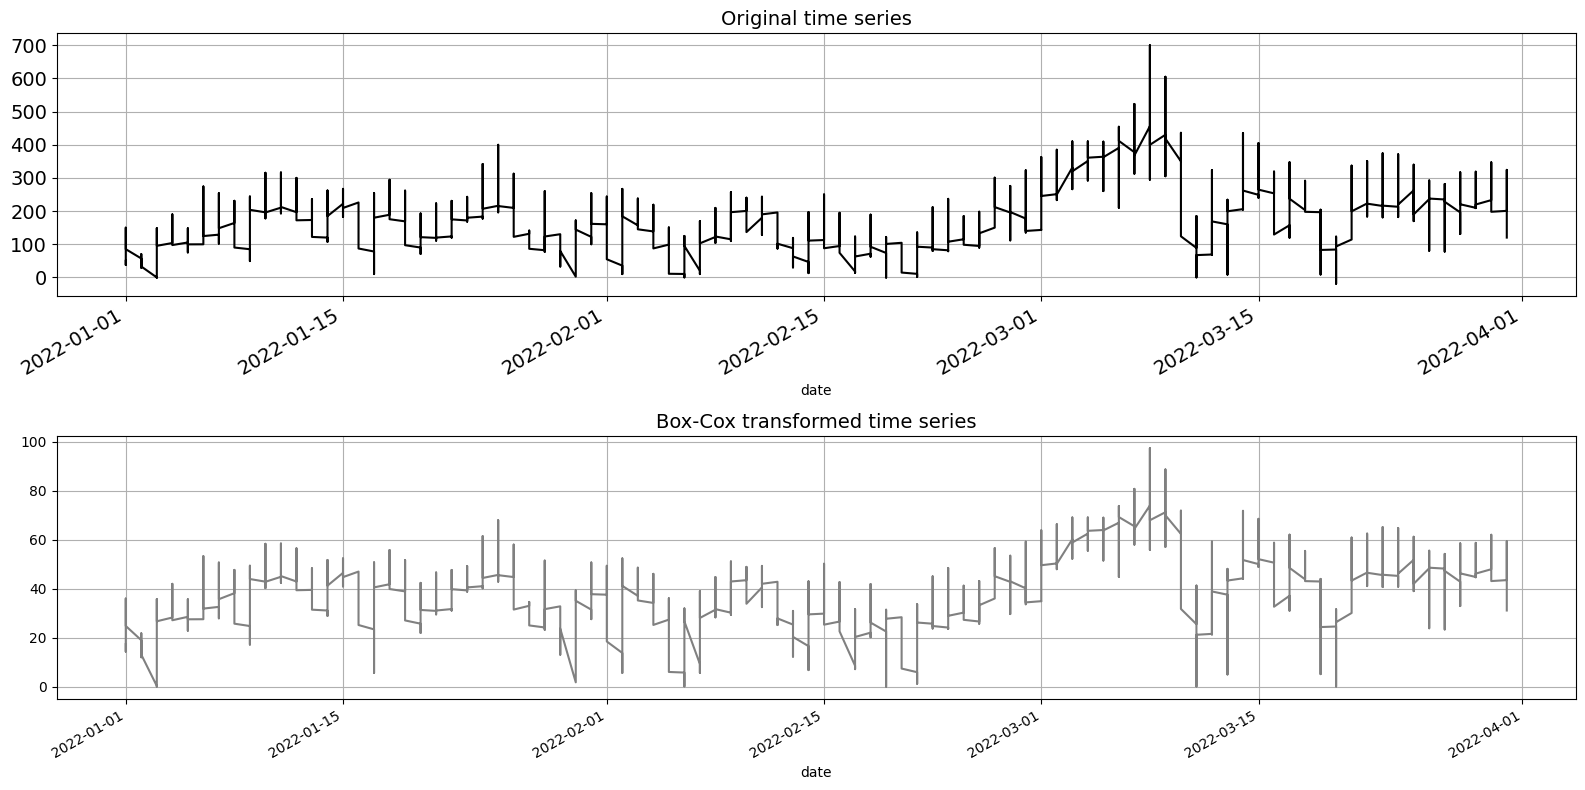

In [ ]:
boxcox_transformed_data, boxcox_lambda = boxcox(abs(values) + 1)
boxcox_transformed_data = pd.Series(boxcox_transformed_data, index=df_daily_training.index)

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
df_plot_training.plot(ax=ax[0], color="black", fontsize=14)
ax[0].set_title("Original time series", fontsize=14)
boxcox_transformed_data.plot(ax=ax[1], color="grey")
ax[1].set_title("Box-Cox transformed time series", fontsize=14)
ax[0].grid()
ax[1].grid()
plt.tight_layout()
plt.gcf()

saved_file_counter += 1
plt.savefig(f"{directory}/{saved_file_counter}_Original_and_box_cox_timer_series_{session_id}.png")

plt.show()
plt.close()

## Stationary check - KPSS test

In [ ]:
#KPPS Test function definition
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

<ipython-input-21-05c99230e043>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)
<ipython-input-21-05c99230e043>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


KPSS Statistic: 1.2114808279850724
p-value: 0.01
num lags: 27
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
KPSS Statistic: 0.03744237495961725
p-value: 0.1
num lags: 49
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


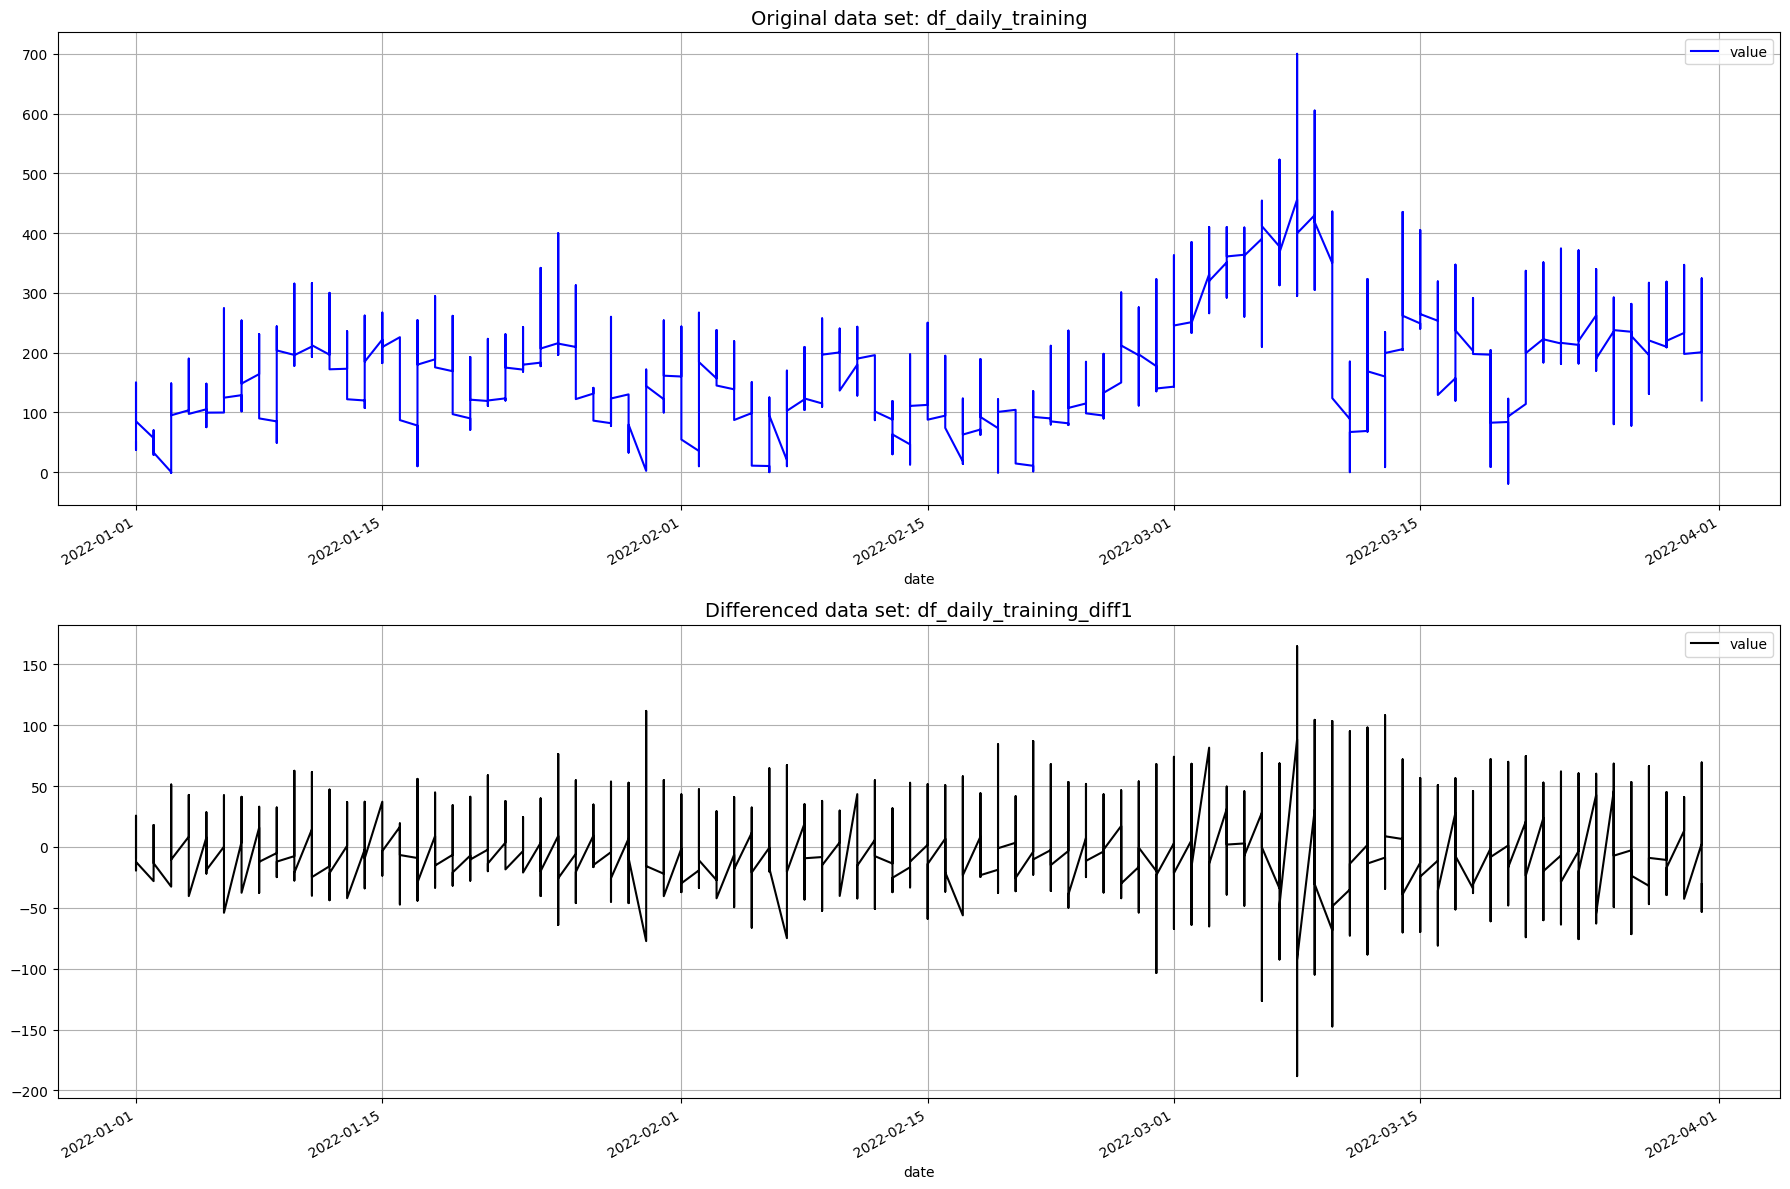

In [ ]:
kpss_test(df_daily_training)
df_daily_training_diff1 = df_daily_training.diff()

# ignore NaN for KPSS
kpss_test(df_daily_training_diff1.dropna())



# Create the plot with subplots
fig, axs = plt.subplots(2, 1, figsize=(18, 12))

# Plot the original data
axs[0].set_title("Original data set: df_daily_training", fontsize=14)
df_daily_training.plot(ax=axs[0], color="blue")
axs[0].grid(True)

# Plot the differenced data
axs[1].set_title("Differenced data set: df_daily_training_diff1", fontsize=14)
df_daily_training_diff1.plot(ax=axs[1], color="black")
axs[1].grid(True)

plt.tight_layout()

plt.gcf()

saved_file_counter += 1
plt.savefig(f"{directory}/{saved_file_counter}_Original_and_differenced_data_sets_{session_id}.png")

plt.show()
plt.close()

## ACF and PACF plots

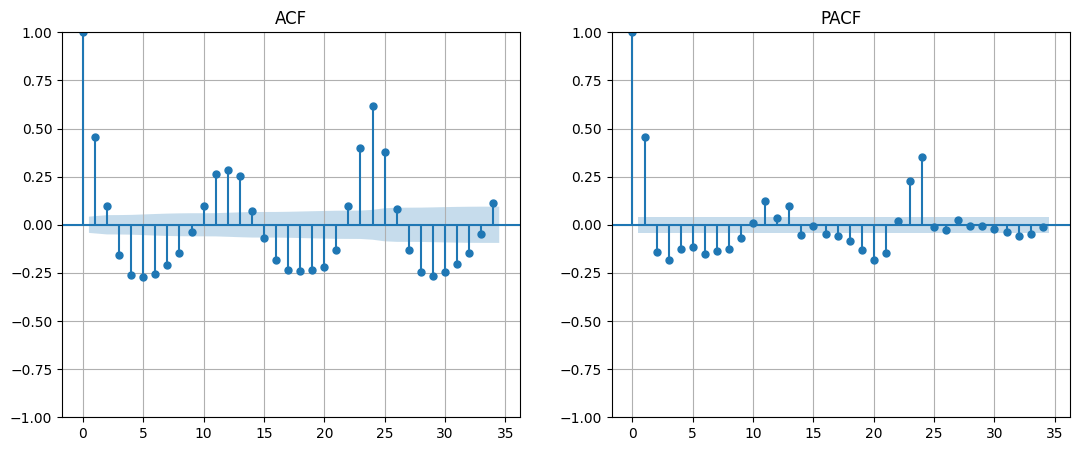

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
plot_acf(df_daily_training_diff1.dropna(), ax=ax[0])
ax[0].set_title("ACF")
plot_pacf(df_daily_training_diff1.dropna(), method="ywm", ax=ax[1])
ax[1].set_title("PACF")
ax[0].grid()
ax[1].grid()

plt.gcf()

saved_file_counter += 1
plt.savefig(f"{directory}/{saved_file_counter}_ACF_PACF_{session_id}.png")

plt.show()
plt.close()



## Fit ARIMA model

In [ ]:
#Fitting ARIMA model with arbitrary order to generate output summary for later comparisons
model = ARIMA(df_daily_training, order=arima_model_order)
fitted = model.fit()
print(fitted.summary())

saved_file_counter += 1
file_name = f"{saved_file_counter}_Fit_Arima_Model_Summary_{start_time}_{session_id}.txt"
file_path = os.path.join(directory, file_name)  # Construct the file path
with open(file_path, "w") as file:
    file.write(fitted.summary().as_text())



                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 2159
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9853.738
Date:                Thu, 27 Jun 2024   AIC                          19713.476
Time:                        02:32:16   BIC                          19730.507
Sample:                             0   HQIC                         19719.705
                               - 2159                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3208      0.034      9.469      0.000       0.254       0.387
ma.L1          0.1759      0.037      4.731      0.000       0.103       0.249
sigma2       541.4641      9.089     59.571      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Auto ARIMA with increased maxiter


In [ ]:
auto_model = auto_arima(df_daily_training, maxiter=100, seasonal=False, stepwise=True, suppress_warnings=True)

# Obtained Auto Model Order
arima_model_order = auto_model.order
print(auto_model.summary())

saved_file_counter += 1
file_name = f"{saved_file_counter}_Auto_ARIMA_with_increased_maxiter_{start_time}_{session_id}.txt"
file_path = os.path.join(directory, file_name)  # Construct the file path
with open(file_path, "w") as file:
    file.write(auto_model.summary().as_text())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2159
Model:               SARIMAX(2, 1, 5)   Log Likelihood               -9615.378
Date:                Thu, 27 Jun 2024   AIC                          19246.756
Time:                        02:33:00   BIC                          19292.172
Sample:                             0   HQIC                         19263.368
                               - 2159                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7305      0.001   1399.407      0.000       1.728       1.733
ar.L2         -0.9981      0.001   -794.077      0.000      -1.001      -0.996
ma.L1         -1.4464      0.016    -89.405      0.0

## Residuals check



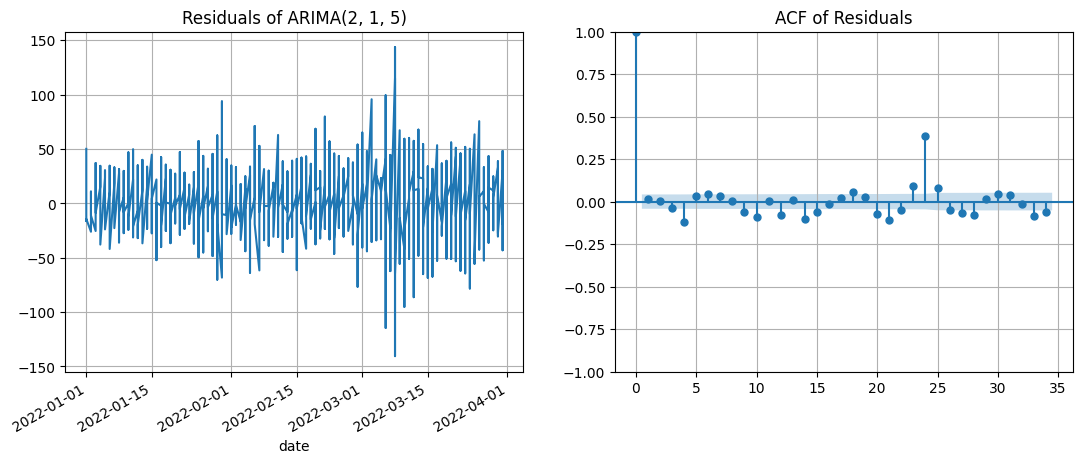

In [ ]:
# Check the residuals
residuals = pd.DataFrame(auto_model.resid())
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
residuals.plot(ax=ax[0], legend=False)
ax[0].grid()
ax[0].set_title(f"Residuals of ARIMA{arima_model_order}")
plot_acf(residuals, ax=ax[1])
ax[1].set_title("ACF of Residuals")
ax[1].grid()

plt.gcf()
saved_file_counter += 1
plt.savefig(f"{directory}/{saved_file_counter}_Residuals_{session_id}.png")
plt.show()
plt.close()



## Ljung-Box test

In [ ]:
# Ljung-Box test
Btest = acorr_ljungbox(auto_model.resid(), lags=[10], return_df=True, model_df=5)
print(Btest)


      lb_stat     lb_pvalue
10  70.367041  8.594972e-14


## Forecast calculation

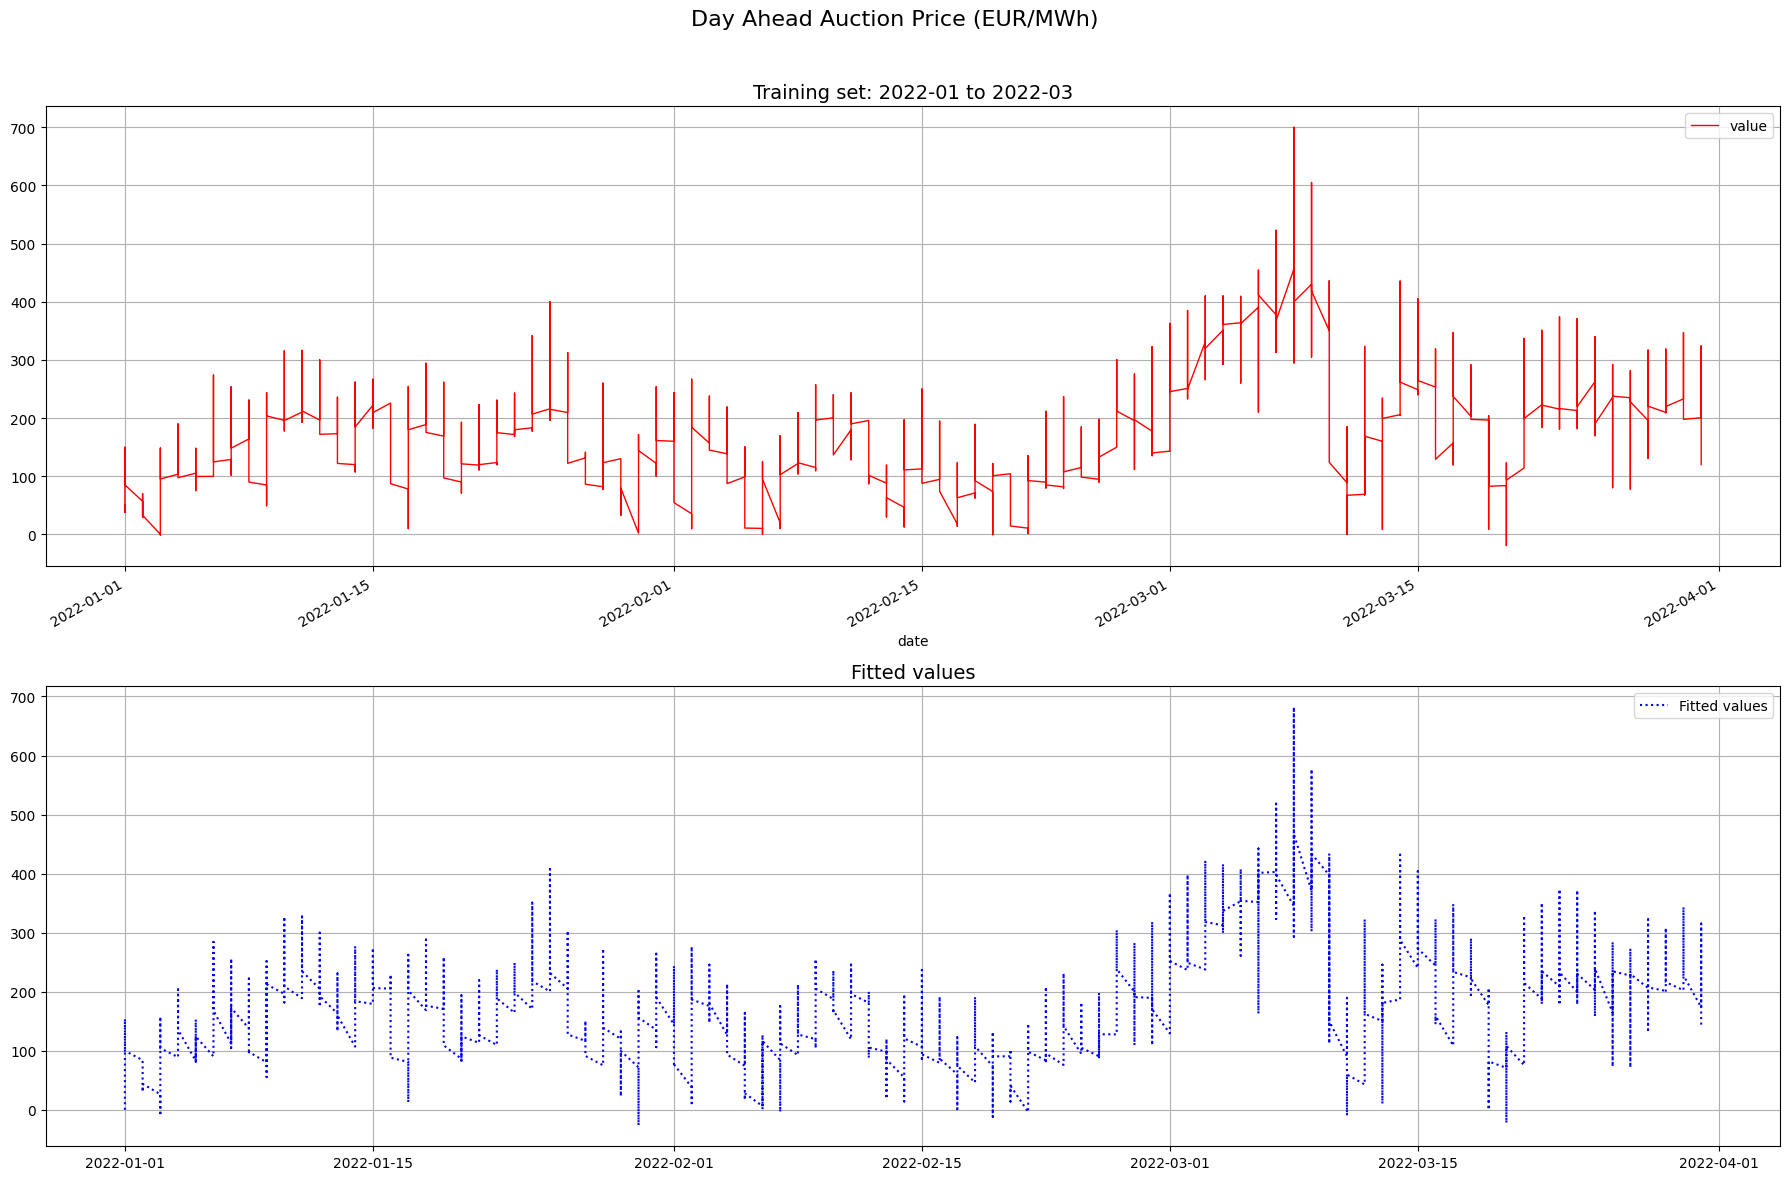

In [ ]:
#Suppress warnings
warnings.filterwarnings("ignore")

# Calculate forecasts
model = ARIMA(df_daily_training, order=arima_model_order)
fitted = model.fit()
forecast_series = fitted.forecast(steps=nsteps, alpha=0.05)

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(18, 12))

# Plot the training data on the first subplot
axs[0].set_title(f"Training set: {start_date_training_year_month} to {end_date_training_year_month}", fontsize=14)
df_daily_training.plot(ax=axs[0], color="red", linestyle='solid', linewidth=1, label="Training set")
axs[0].legend()
axs[0].grid(True)

# Plot the fitted values on the second subplot
axs[1].set_title("Fitted values", fontsize=14)
axs[1].plot(fitted.fittedvalues, color="blue", linestyle=':', label="Fitted values")
axs[1].legend()
axs[1].grid(True)

# Set the main title for the entire figure
fig.suptitle(plot_main_title, fontsize=16)

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.gcf()
saved_file_counter += 1
plt.savefig(f"{directory}/{saved_file_counter}_Training_set_Fitted_Set_{session_id}.png")
plt.show()
plt.close()

## Rolling forecast

In [ ]:
#Remove missing values
df_daily_training.dropna(inplace=True)
df_daily_test.dropna(inplace=True)

In [ ]:
#Suppress console waring outputs
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found. Using zeros as starting parameters.")

#Time start
start_time_rolling_forecast = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
print(f"Rolling forecast model fit and model forecast start time: {start_time_rolling_forecast}")

#Perform rolling forecast
history = list(df_daily_training[value_column_name].values)
print(df_daily_training)
print(df_daily_test)
predictions = []
conf_ints_95 = []
conf_ints_80 = []

for t in range(len(df_daily_test)):
    model = ARIMA(history, order=arima_model_order)
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=nsteps)
    yhat = forecast.predicted_mean[0]
    conf_int_95 = forecast.conf_int(alpha=0.05)
    conf_int_80 = forecast.conf_int(alpha=0.2)
    predictions.append(yhat)
    conf_ints_95.append(conf_int_95[0])
    conf_ints_80.append(conf_int_80[0])
    history.append(df_daily_test[value_column_name].values[t])
    #print(predictions) #Leave for in-line debugging
    #print(history) #Leave for in-line debugging

end_time = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

Rolling forecast model fit and model forecast start time: 2024-06-27_02:33:03
             value
date              
2022-01-01   50.05
2022-01-01   41.33
2022-01-01   43.22
2022-01-01   45.46
2022-01-01   37.67
...            ...
2022-03-31  229.49
2022-03-31  199.08
2022-03-31  164.35
2022-03-31  150.64
2022-03-31  120.08

[2159 rows x 1 columns]
             value
date              
2022-04-01  111.72
2022-04-01   99.64
2022-04-01   94.48
2022-04-01   99.59
2022-04-01  109.02
2022-04-01  140.01
2022-04-01  178.63
2022-04-01  200.03
2022-04-01  208.47
2022-04-01  200.35
2022-04-01  193.08
2022-04-01  181.14
2022-04-01  171.94
2022-04-01  159.91
2022-04-01  147.10
2022-04-01  140.82
2022-04-01  142.33
2022-04-01  172.40
2022-04-01  191.70
2022-04-01  205.96
2022-04-01  200.19
2022-04-01  174.92
2022-04-01  167.85
2022-04-01  151.86


In [ ]:
print(f"Rolling forecast model fit and model forecast end time: {end_time}")

Rolling forecast model fit and model forecast end time: 2024-06-27_02:33:41


## Conversion of predictions and confidence inteverals to series + Plots

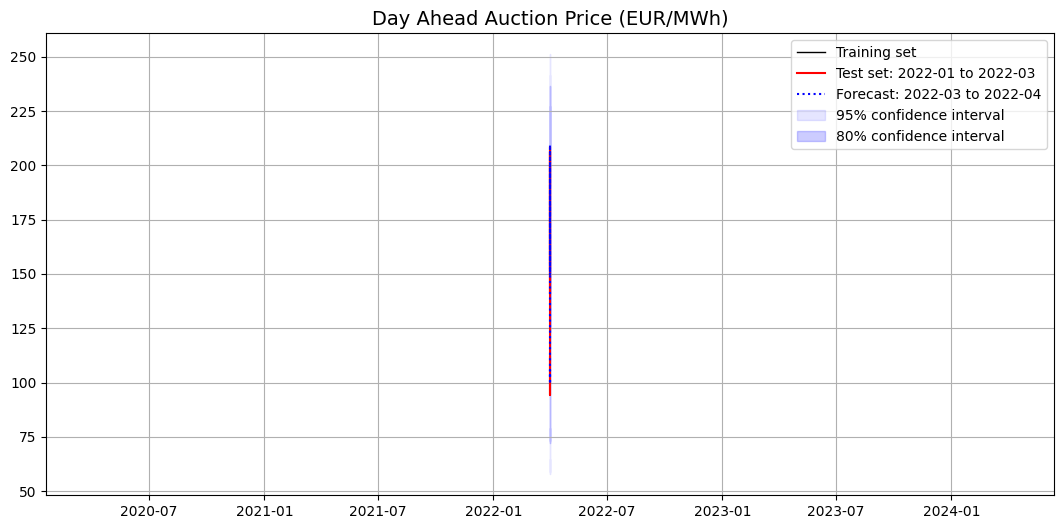

In [ ]:
# Convert predictions and confidence intervals to series
forecast_index = df_daily_test.index
predictions_series = pd.Series(predictions, index=forecast_index)
conf_ints_95_df = pd.DataFrame(conf_ints_95, index=forecast_index, columns=['lower value', 'upper value'])
conf_ints_80_df = pd.DataFrame(conf_ints_80, index=forecast_index, columns=['lower value', 'upper value'])

# Plot the results
plt.figure(figsize=(13, 6))
plt.title(plot_main_title, fontsize=14)



# Plot training data
plt.plot(df_daily_training[start_date_testing:].index, df_daily_training[start_date_testing:].values, color="black", linestyle='solid', linewidth=1, label="Training set")

# Plot test data
plt.plot(df_daily_test.index, df_daily_test.values, color="red", linestyle='solid', label=f"Test set: {start_date_training_year_month} to {end_date_training_year_month}")

# Plot forecast
plt.plot(predictions_series.index, predictions_series.values, color="blue", linestyle=':', label=f"Forecast: {start_date_testing_year_month} to {end_date_testing_year_month}")

# Plot confidence intervals
plt.fill_between(
    conf_ints_95_df.index,
    conf_ints_95_df["lower value"],
    conf_ints_95_df["upper value"],
    color="blue",
    alpha=0.1,
    label="95% confidence interval"
)

plt.fill_between(
    conf_ints_80_df.index,
    conf_ints_80_df["lower value"],
    conf_ints_80_df["upper value"],
    color="blue",
    alpha=0.2,
    label="80% confidence interval"
)

plt.legend()
plt.grid(True)

plt.gcf()
saved_file_counter += 1
plt.savefig(f"{directory}/{saved_file_counter}_Confidence_intervals_predicitions_{session_id}.png")

plt.show()
plt.close()

## Evaluation

In [ ]:
# Calculate error metrics
true_values = df_daily_test.values
forecast_values = predictions_series.values

In [ ]:
#Save test and predictions to a csv file
saved_file_counter += 1
file_name = f"{saved_file_counter}_test_values_and_predictions_{end_time}_{session_id}.csv"
# Define the complete file path
file_path = os.path.join(directory, file_name)

# Combine the data into a DataFrame
combined_df = pd.DataFrame({
    'Date': df_daily_test.index,
    'True Values': df_daily_test['value'],
    'Forecast Values': predictions_series
})

# Save the combined DataFrame to a text file
combined_df.to_csv(file_path, sep=';', index=False, header=True)

In [ ]:
#Debugging to check lenght of true and forecast value lists
print(len(true_values))
print(len(forecast_values))

24
24


In [ ]:
#Optional: if needed remove mutlidimensionality of arrays
true_values = true_values.flatten()
forecast_values = forecast_values.flatten()

In [ ]:
#Remove zero values
non_zero_true = true_values != 0
true_values_nzero = true_values[non_zero_true]
forecast_values_nzero = forecast_values[non_zero_true]

In [ ]:
#Debugging
print(len(true_values_nzero))
print(len(forecast_values_nzero))

24
24


In [ ]:
#Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, forecast_values)
print(f'Mean Absolute Error (MAE): {np.round(mae,5)}')

#Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((true_values_nzero - forecast_values_nzero) / true_values_nzero)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(mape,5)}')

#Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(true_values, forecast_values))
print(f'Root Mean Squared Error (RMSE): {np.round(rmse,5)}')

#Mean Arctangent Absolute Percentage Error
maape = np.mean(np.arctan(np.abs((true_values_nzero - forecast_values_nzero)/true_values_nzero)))
print(f'Mean Arctangent Absolute Percentage Error (MAAPE): {np.round(maape,5)}')

#R2 sklearn's r2_score function
R_2 = r2_score(true_values, forecast_values)
print(f"R²: {np.round(R_2,5)}")

Mean Absolute Error (MAE): 7.93191
Mean Absolute Percentage Error (MAPE): 5.12782
Root Mean Squared Error (RMSE): 9.28103
Mean Arctangent Absolute Percentage Error (MAAPE): 0.05118


## Session metadata


###Text logs

In [ ]:
saved_file_counter += 1
content = f"""
Session ID: {session_id}
Start timestamp: {start_time_rolling_forecast}
End timestamp: {end_time}

nsteps: {nsteps}
Start of Data Series: {df.index.min()}
Start Date of Training: {start_date_training}
End Date of Training: {end_date_training}
Start Date of Testing: {start_date_testing}
Edd Date of Testing: {end_date_testing}

ARIMA Model Order: {arima_model_order}


Mean Absolute Error (MAE): {mae}
Mean Absolute Percentage Error (MAPE): {mape}
Root Mean Squared Error (RMSE): {rmse}
Mean Arctangent Absolute Percentage Error (MAAPE): {maape}
R-squared (R²) value: {R_2}

ARIMA Model Summary:
{model_fit.summary()}

Number saved files in directory: {saved_file_counter}
"""

print(content)


Session ID: 6c917617
Start timestamp: 2024-06-27_02:33:03
End timestamp: 2024-06-27_02:33:41

nsteps: 1
Start of Data Series: 2022-01-01 00:00:00
Start Date of Training: 2022-01-01 00:00:00
End Date of Training: 2022-03-31 23:00:00
Start Date of Testing: 2022-03-31 23:00:00
Edd Date of Testing: 2022-04-01 23:00:00

ARIMA Model Order: (2, 1, 5)


Mean Absolute Error (MAE): 7.931910170548572
Mean Absolute Percentage Error (MAPE): 5.127821474820233
Root Mean Squared Error (RMSE): 9.281033828229797
Mean Arctangent Absolute Percentage Error (MAAPE): 0.051183367235078985
R-squared (R²) value: 0.932460050102955

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2182
Model:                 ARIMA(2, 1, 5)   Log Likelihood               -9716.875
Date:                Thu, 27 Jun 2024   AIC                          19449.751
Time:                        02:33:42   BIC      

In [ ]:
filename = f"{saved_file_counter}_arima_model_logs_{end_time}_{session_id}.txt"
filepath = os.path.join(directory, filename)
print(filepath)
with open(filepath, "w") as file:
    file.write(content)

/content/ElectricityGermany/session_reports/arima_model_info_2024_06_27_02_31_26_6c917617/11_arima_model_logs_2024-06-27_02:33:41_6c917617.txt


### Commit Session Files To Git (Optional)

In [ ]:
#Define your source directory
source_dir = directory

In [ ]:
#Add file to git
!git add "{source_dir}"

In [ ]:
#Commit message
!git commit -m "{end_time}_sess_ID_{session_id}"

[main 4db57ed] 2024-06-27_02:33:41_sess_ID_6c917617
 11 files changed, 131 insertions(+)
 create mode 100644 session_reports/arima_model_info_2024_06_27_02_31_26_6c917617/10_test_values_and_predictions_2024-06-27_02:33:41_6c917617.csv
 create mode 100644 session_reports/arima_model_info_2024_06_27_02_31_26_6c917617/11_arima_model_logs_2024-06-27_02:33:41_6c917617.txt
 create mode 100644 session_reports/arima_model_info_2024_06_27_02_31_26_6c917617/1_Day_Ahead_Auction_Price_(EURMWh)_6c917617.png
 create mode 100644 session_reports/arima_model_info_2024_06_27_02_31_26_6c917617/2_Original_and_box_cox_timer_series_6c917617.png
 create mode 100644 session_reports/arima_model_info_2024_06_27_02_31_26_6c917617/3_Original_and_differenced_data_sets_6c917617.png
 create mode 100644 session_reports/arima_model_info_2024_06_27_02_31_26_6c917617/4_ACF_PACF_6c917617.png
 create mode 100644 session_reports/arima_model_info_2024_06_27_02_31_26_6c917617/5_Fit_Arima_Model_Summary_2024_06_27_02_31_26_6c9

In [ ]:
#Git Push
#Insert code from ReadMe here

Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 96 threads
Compressing objects: 100% (15/15), done.
Writing objects: 100% (15/15), 522.71 KiB | 32.67 MiB/s, done.
Total 15 (delta 3), reused 4 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 2 local objects.
To https://github.com/mzuhh/ElectricityGermany.git
   25d8b54..4db57ed  main -> main
